In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score
import torch
import torchvision

In [43]:
# set cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# set standart plot size to (21,10)
plt.rcParams['figure.figsize'] = (21, 10)

# Seed
seed = 21
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

cuda


# Dataloader

In [44]:
class activityData(torch.utils.data.Dataset):
    '''
    Class for activity data.
    '''
    def __init__(self, url:str):
        data = np.load(file=url, allow_pickle=False)
        self.x = torch.from_numpy(data['X'])
        self.y = torch.from_numpy(data['y'])
        self.n_samples = self.x.shape[0]
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.n_samples

In [45]:
batchsize = 128

# create datasets and dataloaders
dataTrain = activityData(url='train_savgol.npz')
dataTest = activityData(url="test_savgol.npz")
loaderTrain = torch.utils.data.DataLoader(dataset=dataTrain, batch_size=batchsize, shuffle=True)
loaderTest = torch.utils.data.DataLoader(dataset=dataTest, batch_size=batchsize, shuffle=False)

# Define model of CNN

In [46]:
loaderTrain.dataset.x[0].shape, loaderTrain.dataset.y[0].shape

(torch.Size([43, 13]), torch.Size([]))

# Functions for training model

In [47]:
def calcOutputDim(Input:int, kernel:int, padding:int, stride:int):
    '''
    Calculates output width of a convolutional layer.
    '''
    return int((Input - kernel + 2*padding)/stride + 1)

In [48]:
def evalF1(testLoader:torch.utils.data.DataLoader, model):
    targets = np.array([])
    preds = np.array([])
    for index, (data, target) in enumerate(testLoader):
        data = data.unsqueeze(1).float()
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = torch.argmax(output, dim=1).cpu()
        pred = pred.numpy()
        target = target.cpu()
        target = target.numpy()
        targets = np.append(targets, target)
        preds = np.append(preds, pred)
    f1 = f1_score(targets, preds, average='macro')
    print("F1 score:", f1)
    return f1

In [49]:
def train(model, epochs:int, loader, optimizer, criterion):
    model.train()
    loss_hist = []
    loss = 0
    lossepoch = 0

    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(loader):
            data = data.unsqueeze(1).float()
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            loss_hist.append(loss.item())
            lossepoch += loss.item()

            if epoch in list(range(epochs - 10, epochs)) and loss_hist[-2] > loss_hist[-1]:
                best_model = model.state_dict()

        print("loss", lossepoch)
        lossepoch = 0
    
    model.load_state_dict(best_model)

    return loss_hist, model

In [50]:
def evalTest(model, testLoader, criterion, dataset_name:str):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in testLoader:
            data = data.unsqueeze(1).float()
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(testLoader.dataset)
    print('\n{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        dataset_name, test_loss, correct, len(testLoader.dataset),
        100. * correct / len(testLoader.dataset)))

    accuracy = 100. * correct / len(testLoader.dataset)
    return accuracy

In [51]:
# confusion matrix
def confusionMatrix1D(loader, model):
    model.eval()
    confusionMatrix = torch.zeros(7, 7)
    with torch.no_grad():
        for data, target in loader:
            data = data.flatten(1).reshape(data.shape[0], 1, data.shape[1] * data.shape[2]).float().to(device)
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            for t, p in zip(target.view(-1), predicted.view(-1)):
                confusionMatrix[t.long(), p.long()] += 1
    return confusionMatrix

# confusion matrix
def confusionMatrix2D(loader, model):
    model.eval()
    confusionMatrix = torch.zeros(7, 7)
    with torch.no_grad():
        for data, target in loader:
            data = data.unsqueeze(1).float()
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            for t, p in zip(target.view(-1), predicted.view(-1)):
                confusionMatrix[t.long(), p.long()] += 1
    return confusionMatrix


def plotConfusionMatrix(cm):
    labels = ['Sitting', 'Transport', 'Bicycling', 'Walking', 'Elevatoring', 'Jogging', 'Stairway']
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    # annotate n samples
    for i in range(7):
        for j in range(7):
            plt.text(j, i, int(cm[i, j].item()), horizontalalignment='center', verticalalignment='center')
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(7)
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

# Model with 1 convolutional layer

In [52]:
# define model
class CNN(torch.nn.Module):
    def __init__(self, poolingFunction, bnFunction, activationFunction, kernel=None, stride=None, padding=None):
        super(CNN, self).__init__()
        
        # building network with specified number of layers, poolingFunction and bnFunction
        self.network = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=2),
            poolingFunction(kernel_size=2, stride=2, padding=1),
            bnFunction(num_features=16),
            activationFunction(),
        
            # torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            # poolingFunction(kernel_size=2, stride=2, padding=1),
            # bnFunction(num_features=32),
            # activationFunction(),

            # torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            # poolingFunction(kernel_size=2, stride=2, padding=1),
            # bnFunction(num_features=64),
            # activationFunction(),
        )

        self.linStack = torch.nn.Sequential(
            torch.nn.Linear(in_features=2944, out_features=1500),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(num_features=1500),
            torch.nn.Linear(in_features=1500, out_features=7),
        )

    def forward(self, x):
        x = self.network(x)
        x = torch.nn.Flatten(1)(x)
        x = self.linStack(x)
        return x


loss 308.83174151182175
loss 209.16902250051498
loss 182.5836915075779
loss 164.89488005638123
loss 151.98609939217567
loss 140.0482541024685
loss 131.50524181127548
loss 125.39341476559639
loss 120.69721591472626
loss 112.34995773434639
loss 107.80165891349316
loss 102.2249452918768
loss 99.5319263190031
loss 95.33656300604343
loss 90.57089653611183
loss 87.95854790508747
loss 82.75692443549633
loss 81.16634057462215
loss 78.07448053359985
loss 72.4149054735899
loss 73.48721322417259
loss 71.93119284510612
loss 66.59298894554377
loss 65.93449291586876
loss 65.95809929072857
loss 66.65276029706001
loss 62.355800941586494
loss 62.4575075134635
loss 58.02411226183176
loss 55.70257994532585
loss 55.45787077397108
loss 53.634188294410706
loss 51.58186873048544
loss 52.31864596903324
loss 52.75118584930897
loss 51.033332876861095
loss 50.515507094562054
loss 49.365101262927055
loss 47.97911335527897
loss 45.09294315055013
loss 45.26824118942022
loss 45.6043844409287
loss 43.37318070977926
l

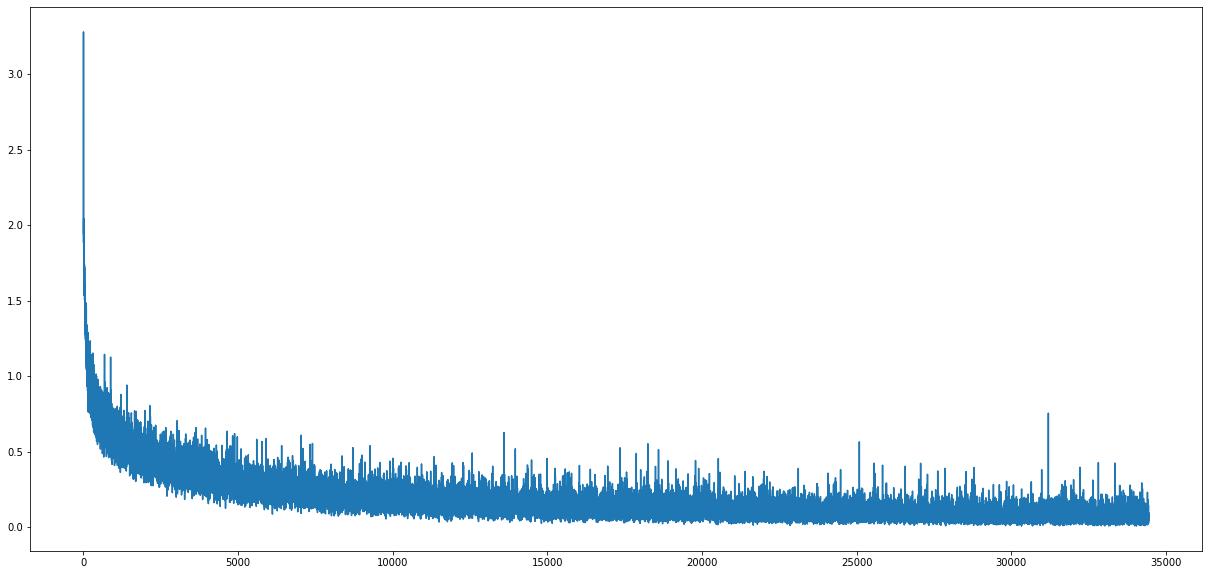

In [53]:
model = CNN(poolingFunction=torch.nn.MaxPool2d, bnFunction=torch.nn.BatchNorm2d, activationFunction=torch.nn.ReLU)
model.to(device)
loss_hist, model = train(model=model, epochs=130, loader=loaderTrain, optimizer=torch.optim.Adam(model.parameters(), lr=1e-3), criterion=torch.nn.CrossEntropyLoss())
evalTest(model=model, testLoader=loaderTest, criterion=torch.nn.CrossEntropyLoss(), dataset_name="Test")
evalTest(model=model, testLoader=loaderTrain, criterion=torch.nn.CrossEntropyLoss(), dataset_name="Train")
evalF1(loaderTest, model)
torch.save(model.state_dict(), "model1.pt")
plt.plot(loss_hist)

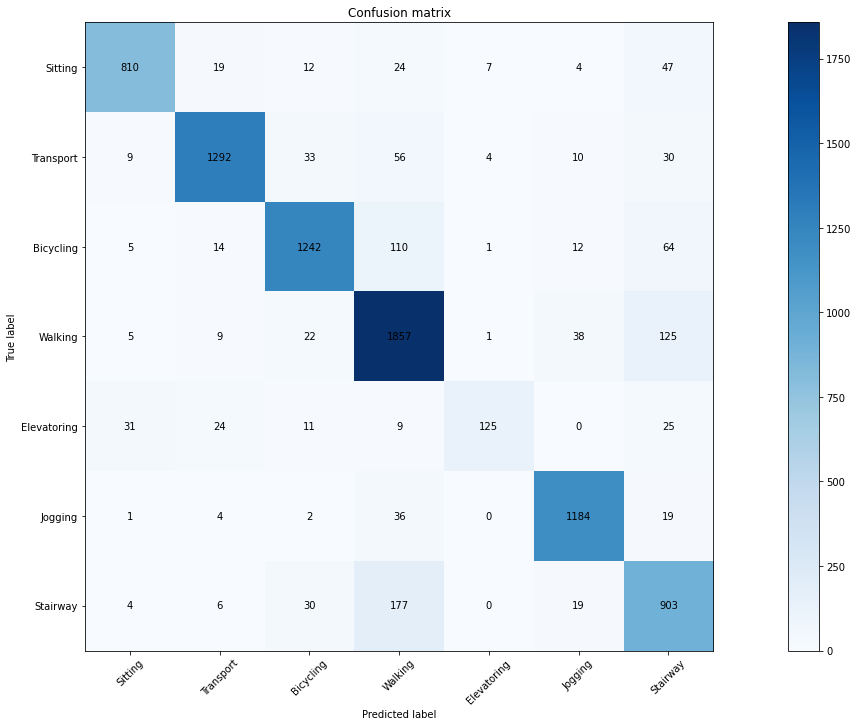

In [54]:
cm = confusionMatrix2D(loaderTest, model)
plotConfusionMatrix(cm)

# Model with 2 convolutional layer

In [55]:
# define model
class CNN(torch.nn.Module):
    def __init__(self, poolingFunction, bnFunction, activationFunction, kernel=None, stride=None, padding=None):
        super(CNN, self).__init__()

        # building network with specified number of layers, poolingFunction and bnFunction
        self.network = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=2),
            poolingFunction(kernel_size=2, stride=2, padding=1),
            bnFunction(num_features=16),
            activationFunction(),
        
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            poolingFunction(kernel_size=2, stride=2, padding=1),
            bnFunction(num_features=32),
            activationFunction(),

            # torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            # poolingFunction(kernel_size=2, stride=2, padding=1),
            # bnFunction(num_features=64),
            # activationFunction(),
        )

        self.linStack = torch.nn.Sequential(
            torch.nn.Linear(in_features=1920, out_features=1000),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(num_features=1000),
            torch.nn.Linear(in_features=1000, out_features=7),
        )

    def forward(self, x):
        x = self.network(x)
        x = torch.nn.Flatten(1)(x)
        x = self.linStack(x)
        return x


loss 316.7956231832504
loss 221.3040618300438
loss 181.92957893013954
loss 159.75764971971512
loss 142.58639073371887
loss 128.22937035560608
loss 118.0030010342598
loss 108.36761564016342
loss 100.41288758814335
loss 93.43718984723091
loss 88.3778462857008
loss 83.05646777153015
loss 80.13501676917076
loss 74.2892232388258
loss 71.05536609888077
loss 65.73654547333717
loss 64.82349655032158
loss 61.88250681757927
loss 57.229412131011486
loss 55.04339597374201
loss 52.786115542054176
loss 49.93676483631134
loss 48.4773645401001
loss 45.2573943734169
loss 42.93088670819998
loss 44.52584774047136
loss 40.88480406999588
loss 40.45496562123299
loss 38.663133677095175
loss 38.695610243827105
loss 37.39924593642354
loss 36.68428232893348
loss 35.09707762673497
loss 33.30524343252182
loss 30.995130334049463
loss 30.7679431065917
loss 30.85632655210793
loss 30.29310344159603
loss 28.03416157886386
loss 28.75753227993846
loss 26.712761640548706
loss 25.712503422051668
loss 26.03665111400187
los

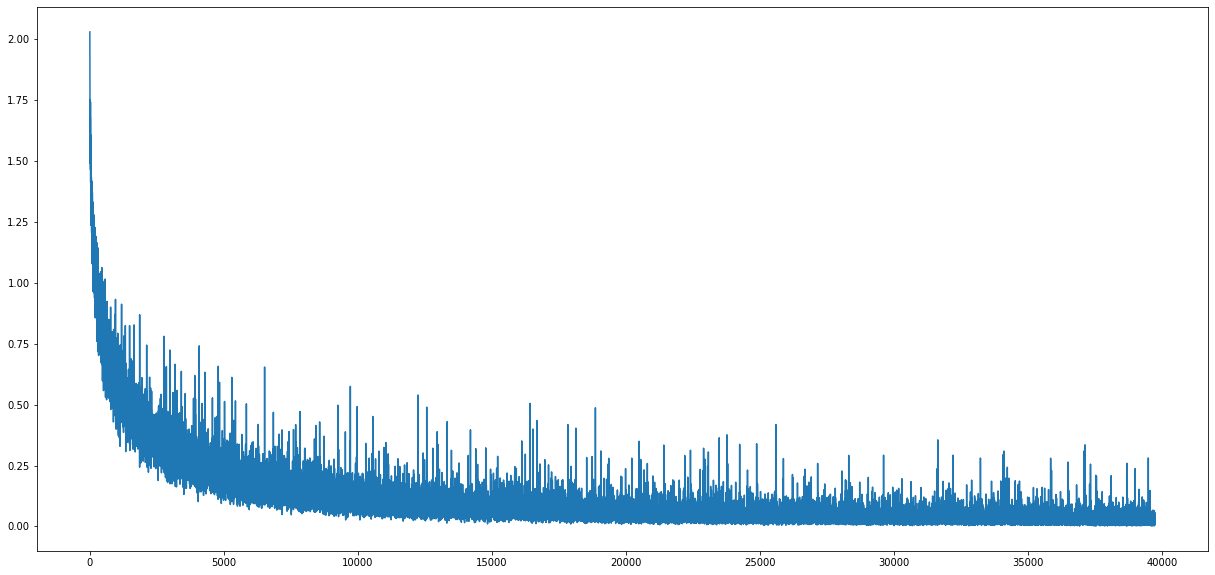

In [56]:
model = CNN(poolingFunction=torch.nn.MaxPool2d, bnFunction=torch.nn.BatchNorm2d, activationFunction=torch.nn.ReLU)
model.to(device)
loss_hist, model = train(model=model, epochs=150, loader=loaderTrain, optimizer=torch.optim.Adam(model.parameters(), lr=1e-4), criterion=torch.nn.CrossEntropyLoss())
evalTest(model=model, testLoader=loaderTest, criterion=torch.nn.CrossEntropyLoss(), dataset_name="test")
evalTest(model=model, testLoader=loaderTrain, criterion=torch.nn.CrossEntropyLoss(), dataset_name="train")
torch.save(model.state_dict(), "model2.pt")
plt.plot(loss_hist)

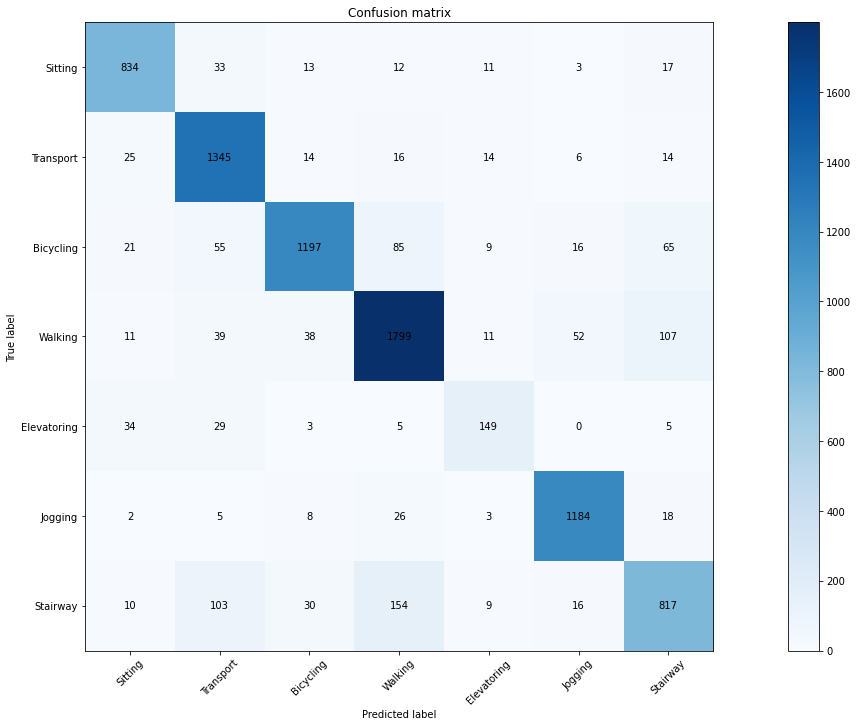

In [57]:
cm = confusionMatrix2D(loaderTest, model)
plotConfusionMatrix(cm)

# Model with 3 convolutional layer

In [58]:
# define model
class CNN(torch.nn.Module):
    def __init__(self, poolingFunction, bnFunction, activationFunction, kernel=None, stride=None, padding=None):
        super(CNN, self).__init__()

        # building network with specified number of layers, poolingFunction and bnFunction
        self.network = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=2),
            poolingFunction(kernel_size=2, stride=2, padding=1),
            bnFunction(num_features=16),
            activationFunction(),
        
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            poolingFunction(kernel_size=2, stride=2, padding=1),
            bnFunction(num_features=32),
            activationFunction(),

            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            poolingFunction(kernel_size=2, stride=2, padding=1),
            bnFunction(num_features=64),
            activationFunction(),
        )

        self.linStack = torch.nn.Sequential(
            torch.nn.Linear(in_features=1344, out_features=672),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(num_features=672),
            torch.nn.Linear(in_features=672, out_features=7),
        )

    def forward(self, x):
        x = self.network(x)
        x = torch.nn.Flatten(1)(x)
        x = self.linStack(x)
        return x


loss 309.3456118106842
loss 206.53562527894974
loss 170.35367467999458
loss 144.2132647037506
loss 129.47301563620567
loss 117.26774078607559
loss 108.08975175023079
loss 99.9234402179718
loss 90.64140151441097
loss 85.15490701794624
loss 80.92571802437305
loss 74.81426081061363
loss 69.43817998468876
loss 66.8783091083169
loss 62.89450144022703
loss 58.98459089547396
loss 56.705215126276016
loss 52.066767141222954
loss 49.48427215218544
loss 45.942829109728336
loss 45.21842733770609
loss 41.144547402858734
loss 40.41424809023738
loss 37.95089865103364
loss 35.8118855021894
loss 35.088940776884556
loss 33.21835021302104
loss 31.330383475869894
loss 31.228412084281445
loss 28.67594600841403
loss 30.012136325240135
loss 27.136294055730104
loss 27.260143846273422
loss 27.73338396847248
loss 24.88951084204018
loss 25.206436892971396
loss 23.56637182086706
loss 22.53007902391255
loss 24.076414296403527
loss 22.146651718765497
loss 21.240495678037405
loss 19.829198975116014
loss 19.810533199

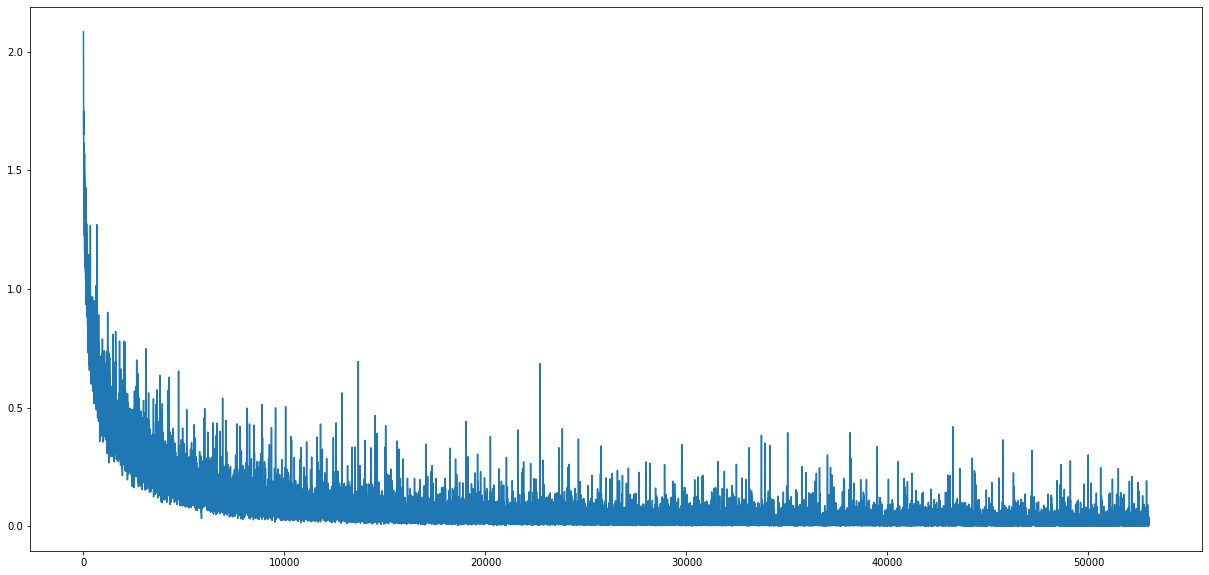

In [59]:
model = CNN(poolingFunction=torch.nn.MaxPool2d, bnFunction=torch.nn.BatchNorm2d, activationFunction=torch.nn.ReLU)
model.to(device)
loss_hist, model = train(model=model, epochs=200, loader=loaderTrain, optimizer=torch.optim.Adam(model.parameters(), lr=1e-4), criterion=torch.nn.CrossEntropyLoss())
evalTest(model=model, testLoader=loaderTest, criterion=torch.nn.CrossEntropyLoss(), dataset_name="test")
evalTest(model=model, testLoader=loaderTrain, criterion=torch.nn.CrossEntropyLoss(), dataset_name="train")
torch.save(model.state_dict(), "model3.pt")
plt.plot(loss_hist)

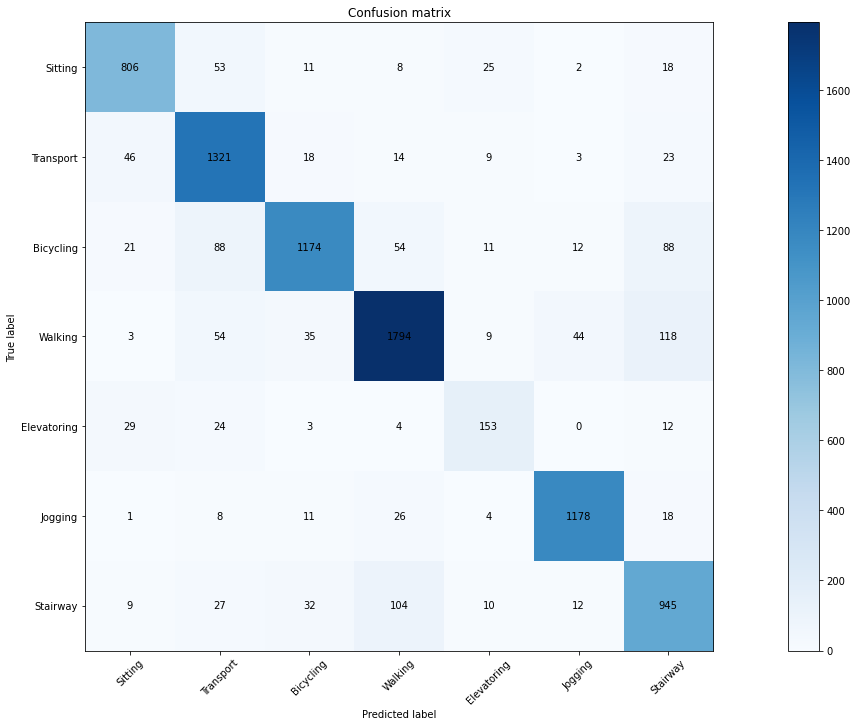

In [60]:
cm = confusionMatrix2D(loaderTest, model)
plotConfusionMatrix(cm)

# CNN with 1D input

In [61]:
data, target = next(iter(loaderTrain))
assert data[0].flatten().shape[0] == 43 * 13
print(43 * 13)

559


In [62]:
# define model
class CNN(torch.nn.Module):
    def __init__(self, poolingFunction, bnFunction, activationFunction, kernel=None, stride=None, padding=None):
        super(CNN, self).__init__()

        # building network with specified number of layers, poolingFunction and bnFunction
        self.network = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=2),
            poolingFunction(kernel_size=2, stride=2, padding=1),
            # bnFunction(num_features=16),
            activationFunction(),
        )

        self.linStack = torch.nn.Sequential(
            torch.nn.Linear(in_features=4496, out_features=2272),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(num_features=2272),
            torch.nn.Linear(in_features=2272, out_features=7),
        )

    def forward(self, x):
        x = self.network(x)
        x = x.flatten(1)
        x = self.linStack(x)
        return x


In [63]:
def train1d(model, epochs:int, loader, optimizer, criterion):
    model.train()
    loss_hist = []
    loss = 0
    lossepoch = 0

    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(loader):
            data = data.flatten(1).reshape(data.shape[0], 1, data.shape[1] * data.shape[2]).float().to(device)
            # data = data.unsqueeze(1).float()
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            loss_hist.append(loss.item())
            lossepoch += loss.item()

            if epoch + 1 == epochs and loss_hist[-2] > loss_hist[-1]:
                best_model = model.state_dict()

        print("loss", lossepoch)
        lossepoch = 0
    
    model.load_state_dict(best_model)

    return loss_hist, model

In [64]:
def evalF1_1D(testLoader:torch.utils.data.DataLoader, model):
    targets = np.array([])
    preds = np.array([])
    for index, (data, target) in enumerate(testLoader):
        data = data.flatten(1).reshape(data.shape[0], 1, data.shape[1] * data.shape[2]).float().to(device)
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = torch.argmax(output, dim=1).cpu()
        pred = pred.numpy()
        target = target.cpu()
        target = target.numpy()
        targets = np.append(targets, target)
        preds = np.append(preds, pred)
    f1 = f1_score(targets, preds, average='macro')
    print("F1 score:", f1)
    return f1

In [65]:
def evalTest1D(model, testLoader, criterion, dataset_name:str):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in testLoader:
            data = data.flatten(1).reshape(data.shape[0], 1, data.shape[1] * data.shape[2]).float().to(device)
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(testLoader.dataset)
    print('\n{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        dataset_name, test_loss, correct, len(testLoader.dataset),
        100. * correct / len(testLoader.dataset)))
    accuracy = 100. * correct / len(testLoader.dataset)
    return accuracy

loss 380.70741498470306
loss 276.12504917383194
loss 241.3456197977066
loss 213.25631839036942
loss 200.77640253305435
loss 188.41504830121994
loss 177.18436688184738
loss 165.7416993379593
loss 158.22719979286194
loss 150.7424156665802
loss 143.558521181345
loss 136.65137952566147
loss 135.33316650986671
loss 130.2250425517559
loss 124.97622483968735
loss 120.92493936419487
loss 117.1405845284462
loss 115.56597895920277
loss 111.23783707618713
loss 108.82828411459923
loss 105.63138979673386
loss 102.47827892005444
loss 105.59891878068447
loss 100.77548688650131
loss 98.30913752317429
loss 96.22103014588356
loss 92.39341385662556
loss 89.82812371850014
loss 90.35212607681751
loss 87.84790582954884
loss 84.75828096270561
loss 82.03210107982159
loss 83.13739295303822
loss 82.09503860771656
loss 82.29547242820263
loss 78.91917909681797
loss 80.40310978889465
loss 74.88079299032688
loss 73.85554518550634
loss 74.53616985678673
loss 70.48234128952026
loss 70.19769518077374
loss 71.851716592

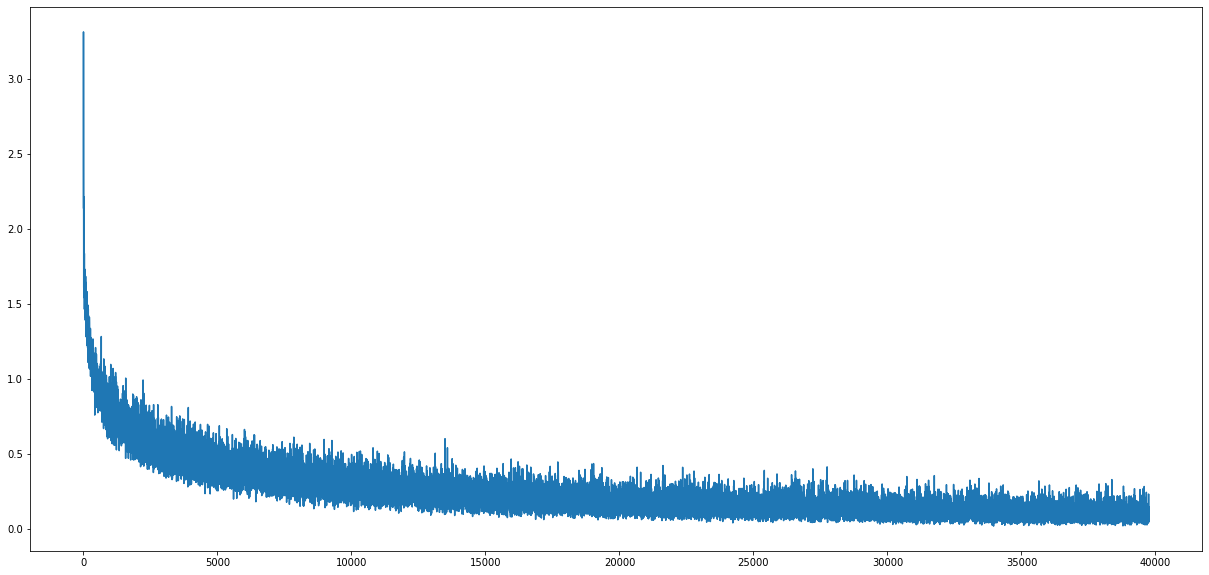

In [66]:
model = CNN(poolingFunction=torch.nn.MaxPool1d, bnFunction=torch.nn.BatchNorm1d, activationFunction=torch.nn.ReLU)
model.to(device)
loss_hist, model = train1d(model, 150, loaderTrain, torch.optim.Adam(model.parameters(), lr=1e-3), torch.nn.CrossEntropyLoss())
evalTest1D(model=model, testLoader=loaderTest, criterion=torch.nn.CrossEntropyLoss(), dataset_name="test")
evalTest1D(model=model, testLoader=loaderTrain, criterion=torch.nn.CrossEntropyLoss(), dataset_name="train")
torch.save(model.state_dict(), "model1d.pt")
plt.plot(loss_hist)

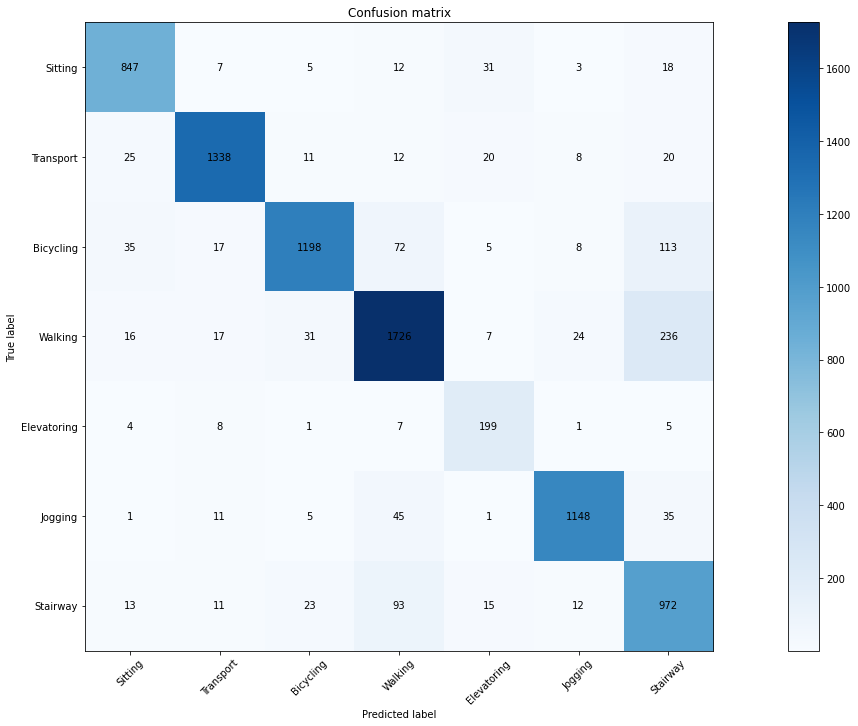

In [68]:
cm = confusionMatrix1D(loaderTest, model)
plotConfusionMatrix(cm)

# Model with three 2D convolutional layers and L2 regularization

In [69]:
# define model
class CNN(torch.nn.Module):
    def __init__(self, poolingFunction, bnFunction, activationFunction, kernel=None, stride=None, padding=None):
        super(CNN, self).__init__()

        # building network with specified number of layers, poolingFunction and bnFunction
        self.network = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=2),
            poolingFunction(kernel_size=2, stride=2, padding=1),
            bnFunction(num_features=16),
            activationFunction(),
        
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            poolingFunction(kernel_size=2, stride=2, padding=1),
            bnFunction(num_features=32),
            activationFunction(),

            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            poolingFunction(kernel_size=2, stride=2, padding=1),
            bnFunction(num_features=64),
            activationFunction(),
        )

        self.linStack = torch.nn.Sequential(
            torch.nn.Linear(in_features=1344, out_features=672),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(num_features=672),
            torch.nn.Linear(in_features=672, out_features=7),
        )

    def forward(self, x):
        x = self.network(x)
        x = torch.nn.Flatten(1)(x)
        x = self.linStack(x)
        return x


In [70]:
def trainL2(model, epochs:int, lm, loader, optimizer, criterion):
    model.train()
    loss_hist = []
    loss = 0
    lossepoch = 0

    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(loader):
            data = data.unsqueeze(1).float()
            # data = data.unsqueeze(1).float()
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)

            # adding l2
            weights = list(model.parameters())[0::2]
            l2_loss = 0

            for param in weights:
                l2_loss += torch.square(param).sum()

            l2_loss = lm * l2_loss
            
            # adding l1 to loss
            loss += l2_loss


            loss.backward()
            optimizer.step()
            loss_hist.append(loss.item())
            lossepoch += loss.item()

            if epoch + 1 == epochs and loss_hist[-2] > loss_hist[-1]:
                best_model = model.state_dict()

        print("loss", lossepoch)
        lossepoch = 0
    
    model.load_state_dict(best_model)

    return loss_hist, model

In [71]:
lms = [0.1, 0.01, 0.001, 0.0001, 0.00001]
lossHists = []
trainScores = []
testScores = []
f1Scores = []

for lm in lms:
    model = CNN(poolingFunction=torch.nn.MaxPool2d, bnFunction=torch.nn.BatchNorm2d, activationFunction=torch.nn.ReLU)
    model.to(device)
    loss_hist, model = trainL2(model=model, epochs=150, lm=lm,loader=loaderTrain, optimizer=torch.optim.Adam(model.parameters(), lr=1e-3), criterion=torch.nn.CrossEntropyLoss())
    lossHists.append(loss_hist)
    testScore = evalTest(model=model, testLoader=loaderTest, criterion=torch.nn.CrossEntropyLoss(), dataset_name="Test")
    testScores.append(testScore)
    trainScore = evalTest(model=model, testLoader=loaderTrain, criterion=torch.nn.CrossEntropyLoss(), dataset_name="Train")
    trainScores.append(trainScore)
    f1Score = evalF1(loaderTest, model)
    f1Scores.append(f1Score)

loss 16923.751823425293
loss 9080.588945388794
loss 4621.018187522888
loss 2193.999071598053
loss 1069.239578485489
loss 649.8989412784576
loss 530.2725616693497
loss 502.612676858902
loss 492.3792173862457
loss 488.41002118587494
loss 487.3992350101471
loss 486.86024022102356
loss 485.3008416891098
loss 483.3608819246292
loss 481.6588091850281
loss 480.5239453315735
loss 481.8061236143112
loss 479.4002078771591
loss 480.88626778125763
loss 479.10900604724884
loss 476.23547863960266
loss 474.90388679504395
loss 473.5299617052078
loss 471.375311255455
loss 470.1420753002167
loss 468.757218003273
loss 468.5768715143204
loss 467.1507902145386
loss 465.86517465114594
loss 465.6794160604477
loss 464.7217515707016
loss 464.5365180969238
loss 464.56632256507874
loss 464.09118688106537
loss 463.8216736316681
loss 463.17977952957153
loss 463.0959051847458
loss 462.6373291015625
loss 462.50163877010345
loss 462.36837089061737
loss 465.010005235672
loss 463.345507144928
loss 462.55530834198
loss 

Lambda 0.1, Train: 60.05252751792723, Test: 59.714353163361665, F1: 0.4067138897902597
Lambda 0.01, Train: 50.945790421105436, Test: 49.71671388101983, F1: 0.3534672625782714
Lambda 0.001, Train: 73.55032903473308, Test: 69.19263456090651, F1: 0.5777617472138662
Lambda 0.0001, Train: 85.1063829787234, Test: 78.9423984891407, F1: 0.7217249741653211
Lambda 1e-05, Train: 87.36683684008617, Test: 80.08734655335222, F1: 0.7736209780506957


Text(0.5, 1.0, 'Loss vs epoch for different lms')

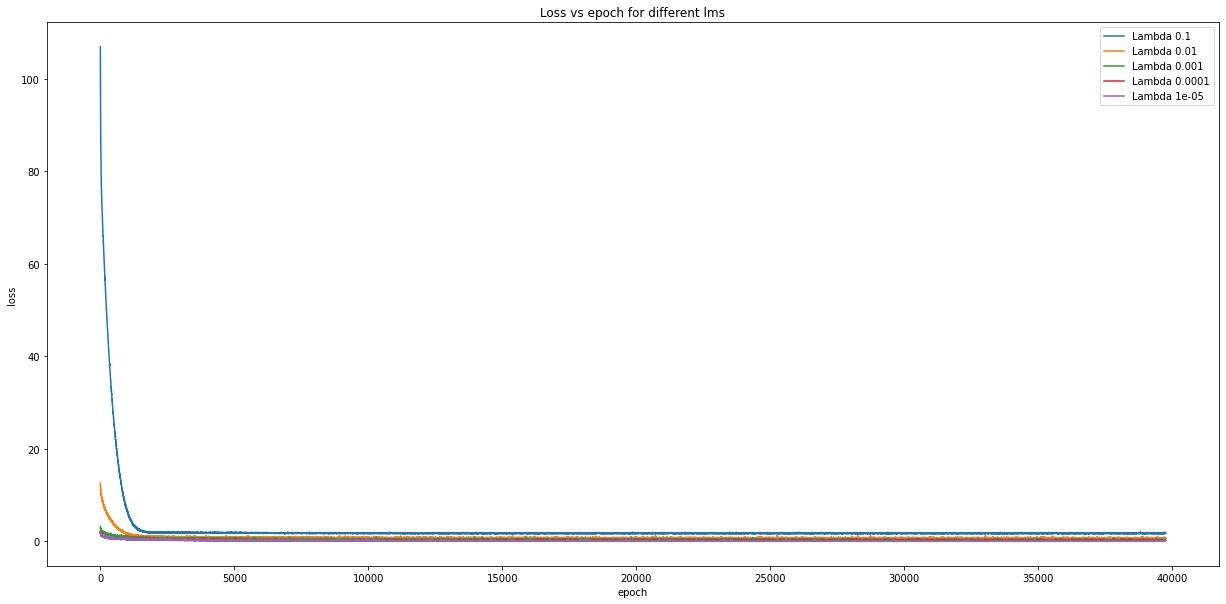

In [72]:
# plot lossHists for different lms and train/test/f1 scores
plt.figure()
for i in range(len(lossHists)):
    plt.plot(lossHists[i], label=f"Lambda {lms[i]}")
    print("Lambda " + str(lms[i]) + ", Train: " + str(trainScores[i]) + ", Test: " + str(testScores[i]) + ", F1: " + str(f1Scores[i]))
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss vs epoch for different lms")

# Model with 1D convolution

In [73]:
# define model
class CNN(torch.nn.Module):
    def __init__(self, poolingFunction, bnFunction, activationFunction, kernel=None, stride=None, padding=None):
        super(CNN, self).__init__()

        # building network with specified number of layers, poolingFunction and bnFunction
        self.network = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=2),
            poolingFunction(kernel_size=2, stride=2, padding=1),
            # bnFunction(num_features=16),
            activationFunction(),
        )

        self.linStack = torch.nn.Sequential(
            torch.nn.Linear(in_features=4496, out_features=2272),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(num_features=2272),
            torch.nn.Linear(in_features=2272, out_features=7),
        )

    def forward(self, x):
        x = self.network(x)
        x = x.flatten(1)
        x = self.linStack(x)
        return x


In [74]:
def trainL2_1D(model, epochs:int, lm, loader, optimizer, criterion):
    model.train()
    loss_hist = []
    loss = 0
    lossepoch = 0

    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(loader):
            data = data.flatten(1).reshape(data.shape[0], 1, data.shape[1] * data.shape[2]).float().to(device)
            # data = data.unsqueeze(1).float()
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)

            # adding l2
            weights = list(model.parameters())[0::2]
            l2_loss = 0

            for param in weights:
                l2_loss += torch.square(param).sum()

            l2_loss = lm * l2_loss
            
            # adding l1 to loss
            loss += l2_loss


            loss.backward()
            optimizer.step()
            loss_hist.append(loss.item())
            lossepoch += loss.item()

            if epoch in list(range(epochs-10, epochs)) and loss_hist[-2] > loss_hist[-1]:
                best_model = model.state_dict()

        print("loss", lossepoch)
        lossepoch = 0
    
    model.load_state_dict(best_model)

    return loss_hist, model

In [75]:
lms = [0.1, 0.01, 0.001, 0.0001, 0.00001]
lossHists = []
trainScores = []
testScores = []
f1Scores = []

for lm in lms:
    model = CNN(poolingFunction=torch.nn.MaxPool1d, bnFunction=torch.nn.BatchNorm1d, activationFunction=torch.nn.ReLU)
    model.to(device)
    loss_hist, model = trainL2_1D(model=model, epochs=75, lm=lm,loader=loaderTrain, optimizer=torch.optim.Adam(model.parameters(), lr=1e-3), criterion=torch.nn.CrossEntropyLoss())
    lossHists.append(loss_hist)
    testScore = evalTest1D(model=model, testLoader=loaderTest, criterion=torch.nn.CrossEntropyLoss(), dataset_name="Test")
    testScores.append(testScore)
    trainScore = evalTest1D(model=model, testLoader=loaderTrain, criterion=torch.nn.CrossEntropyLoss(), dataset_name="Train")
    trainScores.append(trainScore)
    f1Score = evalF1_1D(loaderTest, model)
    f1Scores.append(f1Score)

loss 47743.83534240723
loss 25985.71329498291
loss 12985.462795257568
loss 5895.0993003845215
loss 2502.1611700057983
loss 1126.1544616222382
loss 658.0703582763672
loss 529.9226484298706
loss 499.51364064216614
loss 492.0972384214401
loss 489.878865480423
loss 489.39919435977936
loss 488.7050988674164
loss 488.3435642719269
loss 487.96216559410095
loss 487.6159658432007
loss 487.3456805944443
loss 487.1545844078064
loss 486.98211550712585
loss 486.9162973165512
loss 486.82927894592285
loss 486.71011328697205
loss 486.674595952034
loss 486.6470218896866
loss 486.6296007633209
loss 486.648632645607
loss 486.65165066719055
loss 486.63002622127533
loss 486.6447912454605
loss 486.6587028503418
loss 486.65856873989105
loss 486.6547038555145
loss 486.72210371494293
loss 486.7226138114929
loss 486.6974204778671
loss 486.76061058044434
loss 486.7708956003189
loss 486.77882170677185
loss 486.83936846256256
loss 486.89455568790436
loss 486.7725203037262
loss 486.84494626522064
loss 486.923738241

Lambda 0.1, Train: 24.27479564434739, Test: 24.279981114258735, F1: 0.0558186233938917
Lambda 0.01, Train: 58.24652521615959, Test: 57.34183191690274, F1: 0.4496417570715728
Lambda 0.001, Train: 71.46988520671644, Test: 68.90934844192634, F1: 0.6482296735187102
Lambda 0.0001, Train: 81.08419157789123, Test: 77.2780925401322, F1: 0.7216787431378571
Lambda 1e-05, Train: 88.16065157730102, Test: 82.37724268177526, F1: 0.8127232042426271


Text(0.5, 1.0, 'Loss vs epoch for different lms')

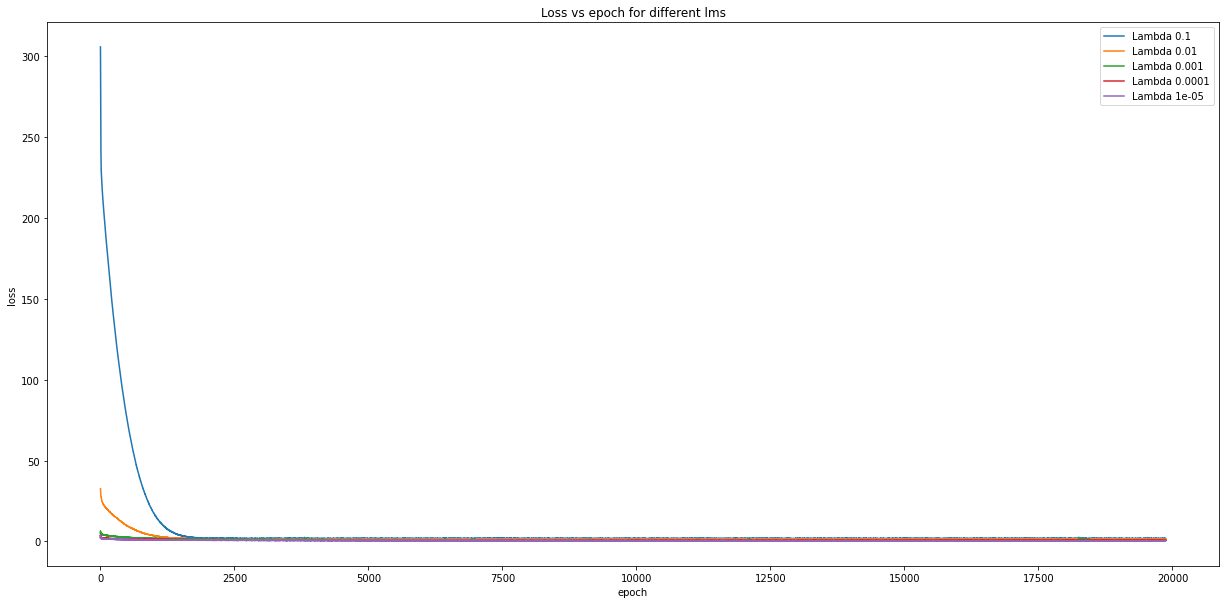

In [76]:
# plot lossHists for different lms and train/test/f1 scores
plt.figure()
for i in range(len(lossHists)):
    plt.plot(lossHists[i], label=f"Lambda {lms[i]}")
    print("Lambda " + str(lms[i]) + ", Train: " + str(trainScores[i]) + ", Test: " + str(testScores[i]) + ", F1: " + str(f1Scores[i]))
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss vs epoch for different lms")

# Bestes Modell 1D Input

In [77]:
model = CNN(poolingFunction=torch.nn.MaxPool1d, bnFunction=torch.nn.BatchNorm1d, activationFunction=torch.nn.ReLU)
model.to(device)
loss_hist, model = trainL2_1D(model=model, epochs=300, lm=0.00001,loader=loaderTrain, optimizer=torch.optim.Adam(model.parameters(), lr=1e-4), criterion=torch.nn.CrossEntropyLoss())
testScore = evalTest1D(model=model, testLoader=loaderTest, criterion=torch.nn.CrossEntropyLoss(), dataset_name="Test")
trainScore = evalTest1D(model=model, testLoader=loaderTrain, criterion=torch.nn.CrossEntropyLoss(), dataset_name="Train")
f1Score = evalF1_1D(loaderTest, model)
torch.save(model.state_dict(), "best_model_1D_savgol.pt")

loss 373.0856980085373
loss 289.237459897995
loss 254.37088465690613
loss 235.23354357481003
loss 221.34036189317703
loss 210.33175164461136
loss 202.4474071264267
loss 194.2768651843071
loss 186.5904387831688
loss 182.29596811532974
loss 172.4859414100647
loss 167.6888925433159
loss 165.00573727488518
loss 159.6945219039917
loss 156.55305072665215
loss 151.08129170536995
loss 147.5281543135643
loss 143.63216125965118
loss 140.9364015161991
loss 137.87865480780602
loss 135.88828524947166
loss 131.42136386036873
loss 129.53574731945992
loss 125.58192166686058
loss 125.80492174625397
loss 122.18582972884178
loss 118.30177041888237
loss 114.56994780898094
loss 112.15983441472054
loss 111.71988800168037
loss 109.40674462914467
loss 108.17625606060028
loss 107.09783840179443
loss 104.31529574096203
loss 104.87599384784698
loss 103.40843059122562
loss 100.5633296072483
loss 99.03093813359737
loss 96.9436254054308
loss 94.8077389895916
loss 93.40418528020382
loss 92.79769836366177
loss 92.063

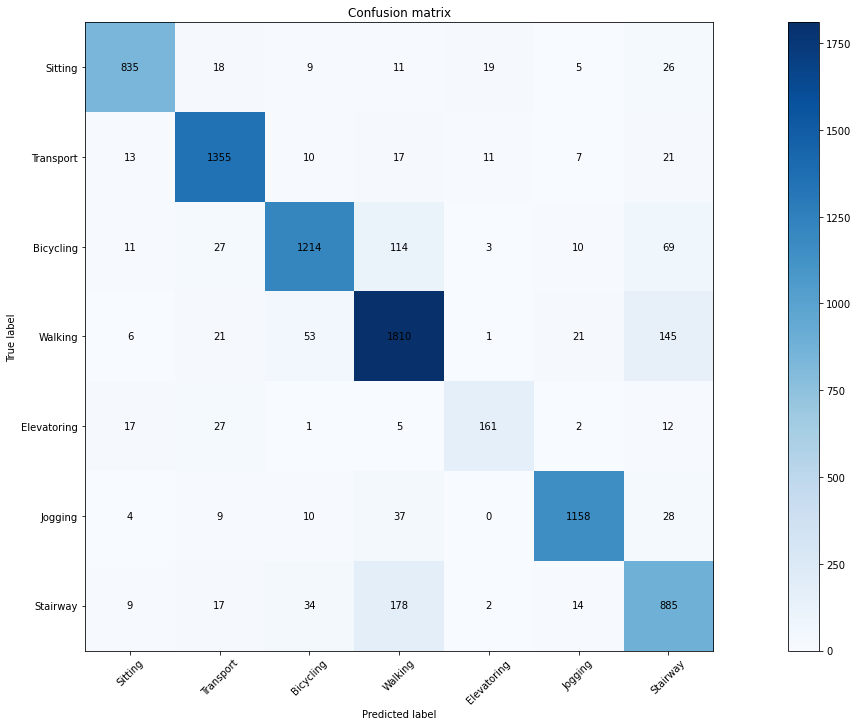

In [78]:
cm = confusionMatrix1D(loaderTest, model)
plotConfusionMatrix(cm)

# Bestes Modell 2D Input

## Modell

In [79]:
# define model
class CNN(torch.nn.Module):
    def __init__(self, poolingFunction, bnFunction, activationFunction, kernel=None, stride=None, padding=None):
        super(CNN, self).__init__()

        # building network with specified number of layers, poolingFunction and bnFunction
        self.network = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=2),
            poolingFunction(kernel_size=2, stride=2, padding=1),
            activationFunction(),
            # bnFunction(num_features=16),
        
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            poolingFunction(kernel_size=2, stride=2, padding=1),
            activationFunction(),
            # bnFunction(num_features=32),

            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            poolingFunction(kernel_size=2, stride=2, padding=1),
            activationFunction(),
            # bnFunction(num_features=64),
        )

        self.linStack = torch.nn.Sequential(
            torch.nn.Linear(in_features=1344, out_features=672),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(num_features=672),

            torch.nn.Linear(in_features=672, out_features=336),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(num_features=336),

            torch.nn.Linear(in_features=336, out_features=7),
        )

    def forward(self, x):
        x = self.network(x)
        x = torch.nn.Flatten(1)(x)
        x = self.linStack(x)
        return x


loss 426.5272206068039
loss 348.5163924694061
loss 310.7174928188324
loss 280.9471358060837
loss 260.0662684440613
loss 241.37433391809464
loss 227.17667204141617
loss 214.5718453526497
loss 203.92387908697128
loss 194.38660562038422
loss 185.0545115172863
loss 176.98942956328392
loss 169.95893916487694
loss 164.1667778789997
loss 157.95741951465607
loss 153.3802600800991
loss 147.80886244773865
loss 142.728639036417
loss 138.24070101976395
loss 135.06952995061874
loss 131.24003872275352
loss 127.42078065872192
loss 124.24349170923233
loss 122.15540659427643
loss 118.01380923390388
loss 115.19115850329399
loss 112.30846104025841
loss 109.48009386658669
loss 107.28562945127487
loss 105.54653644561768
loss 101.9383443146944
loss 100.57444140315056
loss 98.54027816653252
loss 95.79108807444572
loss 93.69283306598663
loss 91.79943522810936
loss 90.77534176409245
loss 88.08474184572697
loss 86.89167280495167
loss 84.1656426936388
loss 81.72565352916718
loss 80.9232923835516
loss 79.18013115

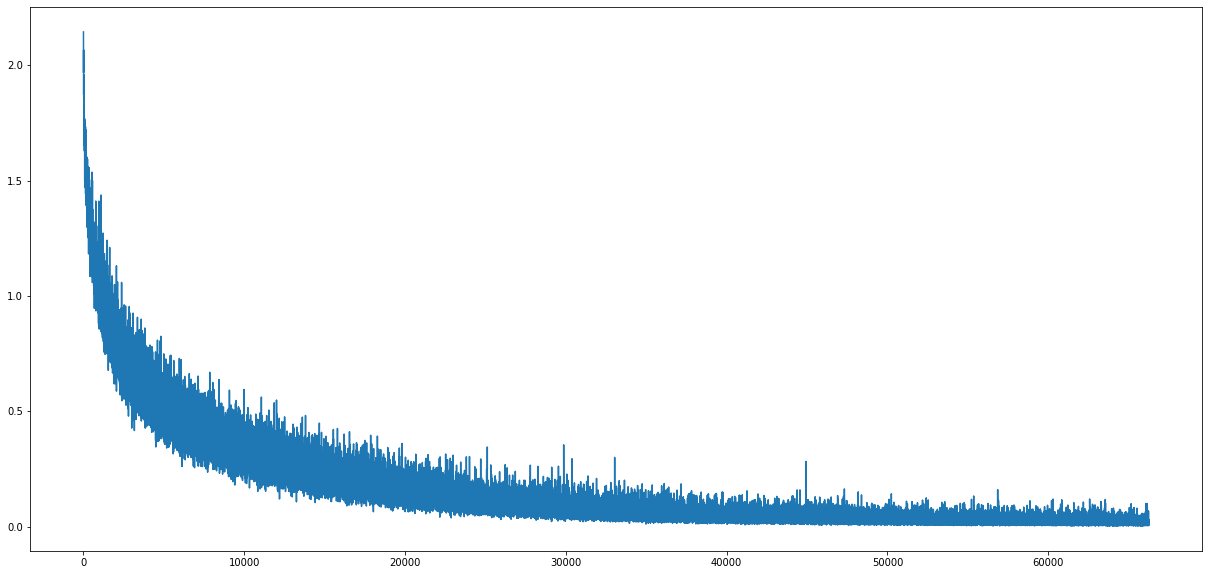

In [80]:
model = CNN(poolingFunction=torch.nn.MaxPool2d, bnFunction=torch.nn.BatchNorm2d, activationFunction=torch.nn.ReLU)
model.to(device)
loss_hist, model = trainL2(model=model, epochs=250, lm=1e-10,loader=loaderTrain, optimizer=torch.optim.Adam(model.parameters(), lr=1e-5), criterion=torch.nn.CrossEntropyLoss())
testScore = evalTest(model=model, testLoader=loaderTest, criterion=torch.nn.CrossEntropyLoss(), dataset_name="Test")
trainScore = evalTest(model=model, testLoader=loaderTrain, criterion=torch.nn.CrossEntropyLoss(), dataset_name="Train")
f1Score = evalF1(loaderTest, model)
plt.plot(loss_hist)
torch.save(model.state_dict(), "best_model_savgol.pt")

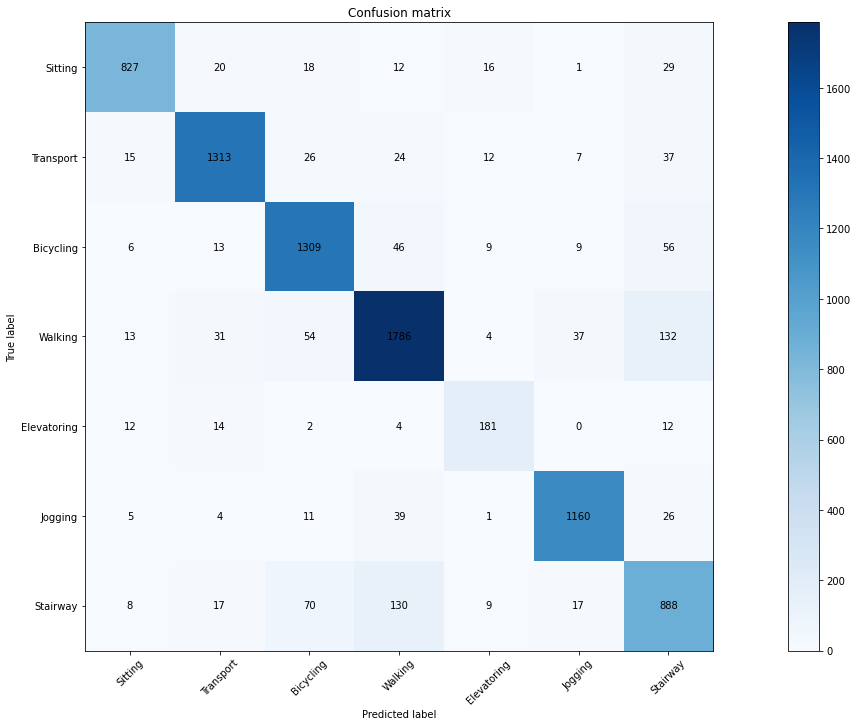

In [81]:
cm = confusionMatrix2D(loaderTest, model)
plotConfusionMatrix(cm)